In [1]:
import sys
import os

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import keras
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score

sys.path.insert(0, "..")
import data_plotting as dplt
import ptf_stuff as ptf
import abcsn_config

from icecream import ic
from importlib import reload

figdir = "./"

2025-07-11 14:30:28.501740: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-11 14:30:28.520264: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-11 14:30:28.525936: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-11 14:30:28.542370: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-11 14:30:30.338752: W tensorflow/compiler/tf2

In [2]:
Xtrn, Xtst, Ytrn, Ytst, num_wvl, num_classes, sn_dict_trn, sn_dict_tst, wvl = ptf.load_data()

In [3]:
model = keras.models.load_model("../abcsn/ABCSN.keras")
pretrain_log = pd.read_csv("../abcsn/pretrain_log.csv")
transfer_log = pd.read_csv("../abcsn/transfer_log.csv")

Ptst = model.predict(Xtst, verbose=0)
Ytst_argmax = np.argmax(Ytst, axis=1)
Ptst_argmax = np.argmax(Ptst, axis=1)

Ptrn = model.predict(Xtrn, verbose=0)
Ytrn_argmax = np.argmax(Ytrn, axis=1)
Ptrn_argmax = np.argmax(Ptrn, axis=1)

I0000 00:00:1752258635.432755   41386 service.cc:146] XLA service 0x2b731c039740 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752258635.432825   41386 service.cc:154]   StreamExecutor device (0): Host, Default Version
2025-07-11 14:30:35.479686: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1752258636.614219   41386 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [4]:
sn_dict_trn

{0: 0, 1: 1, 2: 2, 4: 3, 6: 4, 7: 5, 8: 6, 10: 7, 11: 8, 13: 9}

In [5]:
classes_str = [scs_config.SN_Stypes_str[i] for i, j in sn_dict_trn.items()]
classes_ind = [i for i, j in sn_dict_trn.items()]
classes_ind, classes_str

([0, 1, 2, 4, 6, 7, 8, 10, 11, 13],
 ['Ia-norm',
  'Ia-91T',
  'Ia-91bg',
  'Iax',
  'Ib-norm',
  'Ibn',
  'IIb',
  'Ic-norm',
  'Ic-broad',
  'IIP'])

In [6]:
acc_tst = accuracy_score(Ytst_argmax, Ptst_argmax)
acc_trn = accuracy_score(Ytrn_argmax, Ptrn_argmax)
print(f"ABC-SN Accuracy (Testing Set): {acc_tst*100:.4f}%")
print(f"ABC-SN Accuracy (Training Set): {acc_trn*100:.4f}%")

ABC-SN Accuracy (Testing Set): 85.0532%
ABC-SN Accuracy (Training Set): 98.3317%


In [7]:
f1_tst = f1_score(Ytst_argmax, Ptst_argmax, labels=np.unique(Ytst_argmax), average="macro")
f1_trn = f1_score(Ytrn_argmax, Ptrn_argmax, labels=np.unique(Ytrn_argmax), average="macro")
print(f"ABC-SN Macro F1-Score (Testing Set): {f1_tst*100:.4f}%")
print(f"ABC-SN Macro F1-Score (Training Set): {f1_trn*100:.4f}%")

ABC-SN Macro F1-Score (Testing Set): 83.0079%
ABC-SN Macro F1-Score (Training Set): 98.3080%


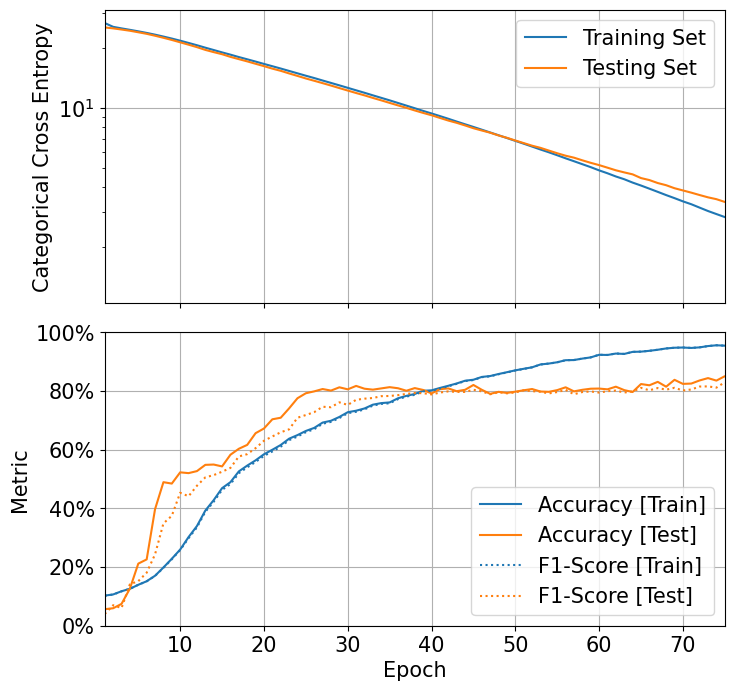

In [8]:
def plot_loss(log, best_epoch, scale=8):
    fontsize = 15
    nrows, ncols = 2, 1
    figsize = (scale, scale)
    fig, axes = plt.subplots(
        nrows,
        ncols,
        sharex=True,
        sharey=False,
        figsize=figsize,
    )
    plt.subplots_adjust(hspace=0.1)

    epochs = log["epoch"] + 1

    # Plot training and testing loss
    axes[0].plot(
        epochs,
        log["loss"],
        c="tab:blue",
        label="Training Set",
    )
    axes[0].plot(
        epochs,
        log["val_loss"],
        c="tab:orange",
        label="Testing Set",
    )

    # Plot training and testing categorical accuracy
    axes[1].plot(
        epochs,
        log["ca"],
        c="tab:blue",
        ls="-",
        label="Accuracy [Train]",
    )
    axes[1].plot(
        epochs,
        log["val_ca"],
        c="tab:orange",
        ls="-",
        label="Accuracy [Test]",
    )

    # Plot training and testing macro F1-score
    axes[1].plot(
        epochs,
        log["f1"],
        c="tab:blue",
        ls=":",
        label="F1-Score [Train]",
    )
    axes[1].plot(
        epochs,
        log["val_f1"],
        c="tab:orange",
        ls=":",
        label="F1-Score [Test]",
    )

    axes[1].set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0], ["0%", "20%", "40%", "60%", "80%", "100%"])

    axes[0].tick_params(axis="both", which="both", labelsize=fontsize)
    axes[1].tick_params(axis="both", which="both", labelsize=fontsize)

    axes[-1].set_xlabel("Epoch", fontsize=fontsize)
    axes[-1].set_xlim((1, best_epoch))

    axes[0].set_ylabel("Categorical Cross Entropy", fontsize=fontsize)
    axes[1].set_ylabel("Metric", fontsize=fontsize)

    # axes[0].set_ylim((None, None))
    axes[1].set_ylim((0, 1))

    axes[0].legend(loc="upper right", fontsize=fontsize)
    axes[1].legend(loc="lower right", fontsize=fontsize)

    axes[0].grid()
    axes[1].grid()

    axes[0].set_yscale("log")
    # axes[1].set_yscale("log")

    return fig

fig = plot_loss(transfer_log, 75, scale=8)
# fig.savefig(os.path.join(figdir, "ABCSN_losscurves.pdf"))

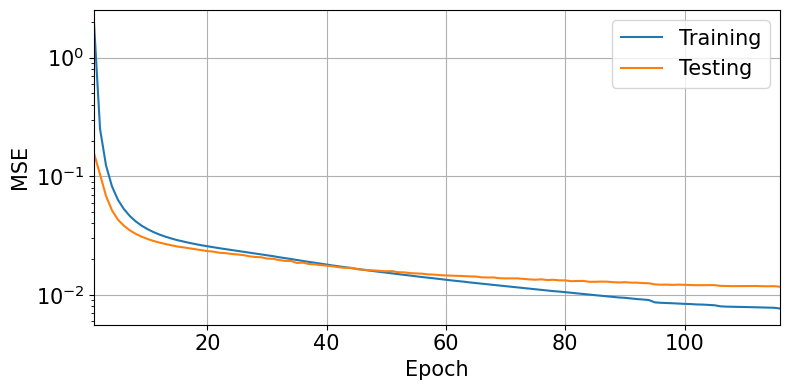

In [9]:
def plot_pretrain_loss(log, best_epoch, scale=8):
    fontsize = 15
    figsize = (scale, scale / 2)
    fig, ax = plt.subplots(1, 1, sharex=True, sharey=False, figsize=figsize)
    fig.subplots_adjust(hspace=0)

    epochs = log["epoch"] + 1
    ax.plot(epochs, log["loss"], c="tab:blue", label="Training")
    ax.plot(epochs, log["val_loss"], c="tab:orange", label="Testing")

    ax.tick_params(axis="both", which="both", labelsize=fontsize)

    ax.set_xlabel("Epoch", fontsize=fontsize)
    ax.set_ylabel("MSE", fontsize=fontsize)
    ax.set_xlim((1, best_epoch))
    ax.legend(loc="upper right", fontsize=fontsize)
    ax.grid()
    ax.set_yscale("log")
    fig.tight_layout()
    return fig

fig = plot_pretrain_loss(pretrain_log, 116, scale=8)
fig.tight_layout()
# fig.savefig(os.path.join(figdir, "ABCSN_pretrain_losscurves.pdf"))

In [10]:
R = 100
classes = [scs_config.SN_Stypes_str[i] for i, j in sn_dict_trn.items()]
print(classes)

# CMtst = confusion_matrix(Ytst_argmax, Ptst_argmax, normalize="pred")
# CMtrn = confusion_matrix(Ytrn_argmax, Ptrn_argmax)

# CMtst, CMtrn

['Ia-norm', 'Ia-91T', 'Ia-91bg', 'Iax', 'Ib-norm', 'Ibn', 'IIb', 'Ic-norm', 'Ic-broad', 'IIP']


In [11]:
def plot_cm(Y, P, classes, normalization="pred", annotations="normalized", title=None):
    textargs = {"fontname": "Serif"}

    cm0 = confusion_matrix(Y, P, normalize=None)
    cmR = confusion_matrix(Y, P, normalize="true")  # Normalize cm by rows
    cmC = confusion_matrix(Y, P, normalize="pred")  # Normalize cm by cols (Our default)
    cmA = confusion_matrix(Y, P, normalize="all")  # Normalize cm by total

    off_diag = ~np.eye(cm0.shape[0], dtype=bool)
    cmR[off_diag] *= -1
    cmC[off_diag] *= -1
    cmA[off_diag] *= -1

    if normalization == "true":
        cm = cmR
    elif normalization == "pred":
        cm = cmC
    elif normalization == "all":
        cm = cmA
    else:
        raise ValueError("`normalization` kwarg must be 'true' 'pred' or 'all'.")

    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(cm, interpolation="none", cmap="RdBu", vmin=-1, vmax=1)

    cbticks = np.linspace(-1, 1, num=9)
    cbticklabels = ["100%", "75%", "50%", "25%", "0%", "25%", "50%", "75%", "100%"]
    cb = plt.colorbar(im, shrink=0.82)
    cb.set_ticks(cbticks, labels=cbticklabels, fontsize=12, **textargs)

    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks, classes, rotation=90, **textargs, fontsize=14)
    ax.set_yticks(tick_marks, classes, **textargs, fontsize=14)

    if title:
        ax.set_title(title)

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            value = int(cm0[i, j])
            valR = np.abs(cmR[i, j])
            valC = np.abs(cmC[i, j])
            valA = np.abs(cmA[i, j])

            if normalization == "true":
                text = f"{valR*100:.1f}" if valR != 1 else "100"
                color = "w" if valR >= 0.50 else "k"
            elif normalization == "pred":
                text = f"{valC*100:.1f}" if valC != 1 else "100"
                color = "w" if valC >= 0.50 else "k"
            elif normalization == "all":
                text = f"{valA*100:.1f}" if valA != 1 else "100"
                color = "w" if valA >= 0.50 else "k"

            if annotations == "absolute":
                text = str(value)
            elif annotations == "normalized":
                pass
            else:
                raise ValueError("`annotations` must be 'normalized' or 'absolute'.")

            if value == 0:
                text = ""

            ax.text(
                j,
                i,
                text,
                ha="center",
                va="center",
                c=color,
                **textargs,
                fontsize=11,
            )

    ax.set_ylabel("True label", fontsize=20, **textargs)
    ax.set_xlabel("Predicted label", fontsize=20, **textargs)

    return fig

In [12]:
# fig_abs = plot_cm(CMtst, classes, R, figsize=(10, 10), title=False, abs_vals=True)
# fig_abs.savefig(os.path.join(figdir, "ABCSN_CM_abs.pdf"))

In [13]:
def plot_double_cm_purity_and_completeness(
    Y,
    P,
    classes,
    title=None,
):
    fs1 = 14
    fs2 = 13
    fs3 = 20
    textargs = {"fontname": "Serif"}

    cm0 = confusion_matrix(Y, P, normalize=None)
    cmR = confusion_matrix(Y, P, normalize="true")  # Normalize cm by rows
    cmC = confusion_matrix(Y, P, normalize="pred")  # Normalize cm by cols (Our default)

    off_diag = ~np.eye(cm0.shape[0], dtype=bool)
    cmR[off_diag] *= -1
    cmC[off_diag] *= -1

    cms = [cmR, cmC]

    fig, axes = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(18, 9))
    fig.subplots_adjust(wspace=0.05)


    for k, (ax, cm) in enumerate(zip(axes, cms)):
        im = ax.imshow(cm, interpolation=None, cmap="RdBu", vmin=-1, vmax=1)

        tick_marks = np.arange(len(classes))
        ax.set_xticks(tick_marks, classes, rotation=90, **textargs, fontsize=fs1)
        ax.set_yticks(tick_marks, classes, **textargs, fontsize=fs1)

        if k == 0:
            ax.set_ylabel("True label", fontsize=fs3, **textargs)
        ax.set_xlabel("Predicted label", fontsize=fs3, **textargs)

        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                val = np.abs(cm[i, j])
                if val == 0:
                    text = ""
                elif val == 1:
                    text = "100"
                else:
                    text = f"{val*100:.1f}"
                color = "w" if val >= 0.50 else "k"
                ax.text(
                    j, i, text,
                    ha="center", va="center",
                    c=color, **textargs, fontsize=fs2,
                )

    cbticks = np.linspace(-1, 1, num=9)
    cbticklabels = ["100%", "75%", "50%", "25%", "0%", "25%", "50%", "75%", "100%"]
    cb = plt.colorbar(
        im,
        ax=axes,
        orientation="vertical",
        location="right",
        anchor=(-0.3, 0.55),
        # aspect=75,
        shrink=0.75,
    )
    cb.set_ticks(cbticks, labels=cbticklabels, fontsize=15, **textargs)

    axes[0].set_title("Normalized by Row (Completeness)", fontsize=20, **textargs)
    axes[1].set_title("Normalized by Column (Purity)", fontsize=20, **textargs)

    return fig

In [14]:
# fig = plot_double_cm_purity_and_completeness(Ytst_argmax, Ptst_argmax, classes)
# # fig.tight_layout()
# fig.savefig(os.path.join(figdir, "ABCSN_doubleCM.pdf"))
# fig.show()

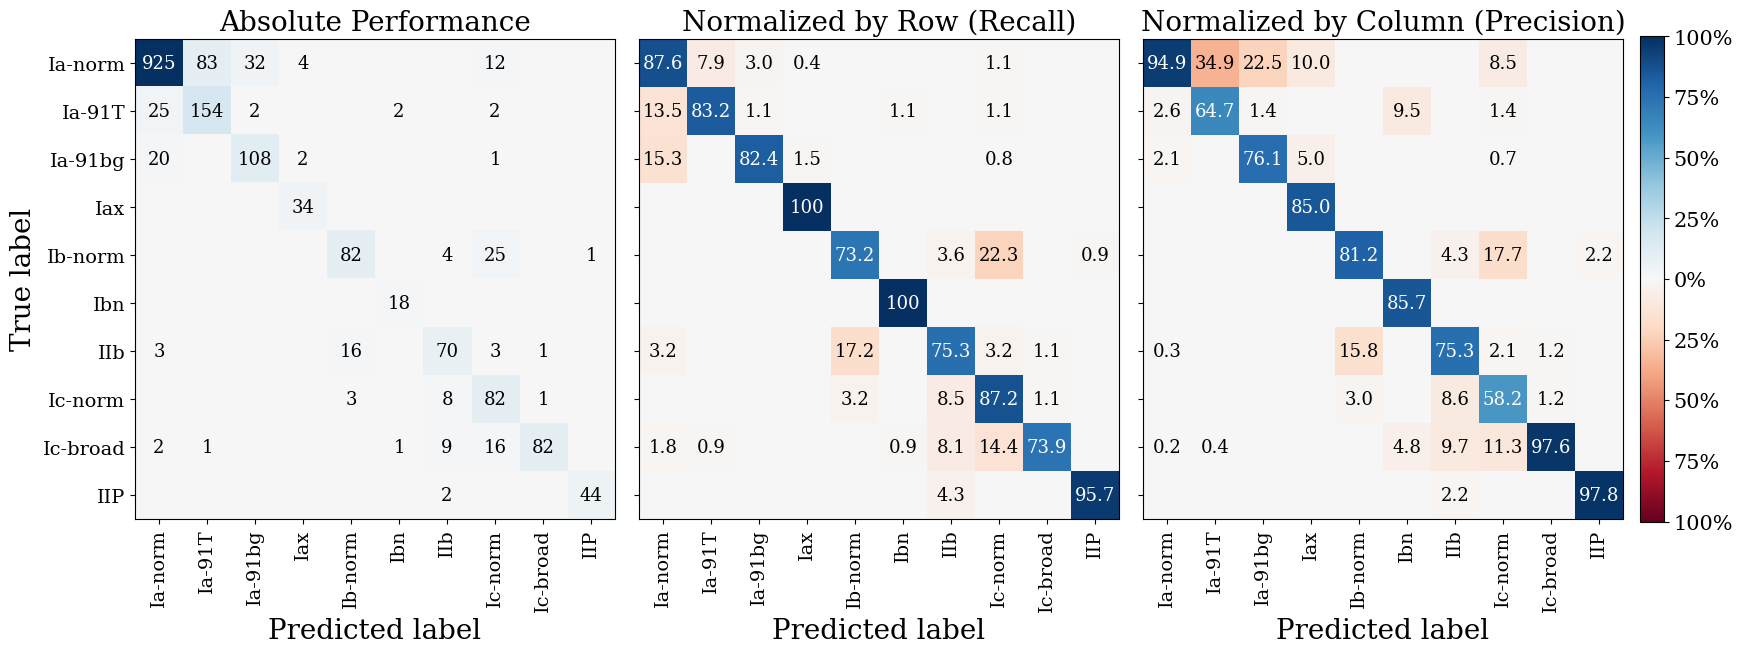

In [15]:
def plot_abcsn_tripleCM(
    Y,
    P,
    classes,
    title=None,
):
    fs1 = 14
    fs2 = 13
    fs3 = 20
    textargs = {"fontname": "Serif"}

    cm0 = confusion_matrix(Y, P, normalize=None)
    cmR = confusion_matrix(Y, P, normalize="true")  # Normalize cm by rows
    cmC = confusion_matrix(Y, P, normalize="pred")  # Normalize cm by cols (Our default)

    off_diag = ~np.eye(cm0.shape[0], dtype=bool)
    cmR[off_diag] *= -1
    cmC[off_diag] *= -1

    cms = [cm0, cmR, cmC]

    fig, axes = plt.subplots(ncols=3, sharex=True, sharey=True, figsize=(24, 18))
    fig.subplots_adjust(wspace=0.05)

    for k, (ax, cm) in enumerate(zip(axes, cms)):
        vmin, vmax = -1, 1
        if k == 0:
            vmin, vmax = -cm.max(), cm.max()
        im = ax.imshow(cm, interpolation=None, cmap="RdBu", vmin=vmin, vmax=vmax)

        tick_marks = np.arange(len(classes))
        ax.set_xticks(tick_marks, classes, rotation=90, **textargs, fontsize=fs1)
        ax.set_yticks(tick_marks, classes, **textargs, fontsize=fs1)

        if k == 0:
            ax.set_ylabel("True label", fontsize=fs3, **textargs)
        ax.set_xlabel("Predicted label", fontsize=fs3, **textargs)

        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                val = np.abs(cm[i, j])
                if val == 0:
                    text = ""
                elif (k != 0) and (val == 1):
                    text = "100"
                elif k != 0:
                    text = f"{val*100:.1f}"
                else:
                    text = str(val)

                if k != 0:
                    color = "w" if val >= 0.50 else "k"
                else:
                    color = "w" if val >= vmax / 2 else "k"
                ax.text(
                    j, i, text,
                    ha="center", va="center",
                    c=color, **textargs, fontsize=fs2,
                )

    cbticks = np.linspace(-1, 1, num=9)
    cbticklabels = ["100%", "75%", "50%", "25%", "0%", "25%", "50%", "75%", "100%"]
    cb = plt.colorbar(
        im,
        ax=axes,
        orientation="vertical",
        location="right",
        anchor=(-0.3, 0.5),
        # aspect=75,
        shrink=0.35,
        # fraction=1,
    )
    cb.set_ticks(cbticks, labels=cbticklabels, fontsize=15, **textargs)

    axes[0].set_title("Absolute Performance", fontsize=20, **textargs)
    axes[1].set_title("Normalized by Row (Recall)", fontsize=20, **textargs)
    axes[2].set_title("Normalized by Column (Precision)", fontsize=20, **textargs)

    return fig


fig = plot_abcsn_tripleCM(Ytst_argmax, Ptst_argmax, classes)
# fig.tight_layout()
# fig.savefig(os.path.join(figdir, "ABCSN_tripleCM.pdf"))
fig.show()